In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')
tf.reset_default_graph()

number_of_training = 60000
batch_size = 64
n_noise = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [14]:
def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x

def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.99
    with tf.variable_scope("generator", reuse=None):
        x = z
        d1 = 4
        d2 = 1
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)      
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)  
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[7, 7])
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        return x

In [15]:
# build computational graph
g = generator(noise, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

# separate parameters of generator and discriminator since we train both networks in an alternating manner
vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]

# L2 regularization for model parameters
d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

# classification loss: real examples belong to class one wherease fake ones belong to class zero.
loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

# generator loss: we want the generated samples to have high probabilities in discriminator network.
# To achieve this, we can maximize a cost function that makes the probability of class zero higher.
# Since it is easier to minimize a cost function, we design the cost function such that it makes lower probabilities
# for class one.
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    # Since we optimize generator and discriminator losses in an alternating manner, we degine two different optimizers.
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_g + g_reg, var_list=vars_g)  

saver = tf.train.Saver()

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(number_of_training):    
    # Booleans to alternate among different optimizers
    train_d = True
    train_g = True
    
    keep_prob_train = 0.6
        
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)   
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]  
    
    # compute generator and discriminator losses
    g_ls, d_ls = sess.run([loss_g, loss_d], feed_dict={X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    if g_ls * 1.5 < d_ls:
        train_g = False
        pass
    if d_ls * 2 < g_ls:
        train_d = False
        pass
    
    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, X_in: batch, keep_prob: keep_prob_train, is_training:True})
         
    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
        
    if (i % 1000 == 0):
      n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)   
      print('iter = %d \t generator = %.4f \t discriminator = %.4f'%(i, g_ls, d_ls))
      s = sess.run(g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:False})
      
      plt.imshow(np.reshape(s[0], [28, 28]), cmap = 'gray')
      plt.show()

save_path = saver.save(sess, './model/tf_model_gan.ckpt')
print("Model saved in path: %s" % save_path)
sess.close()

INFO:tensorflow:Restoring parameters from ./model/tf_model_gan.ckpt


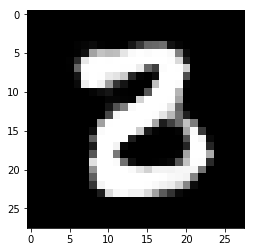

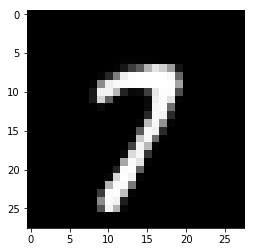

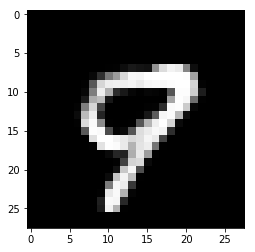

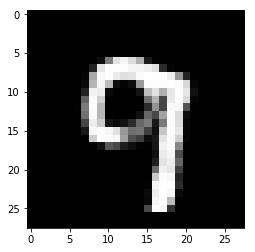

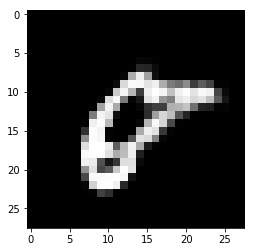

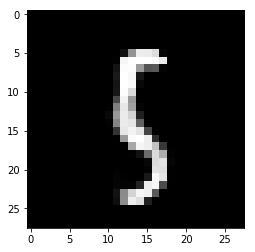

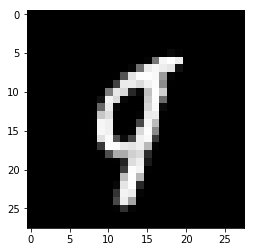

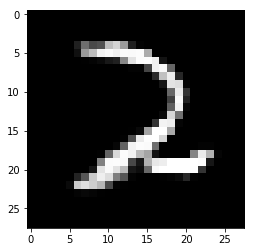

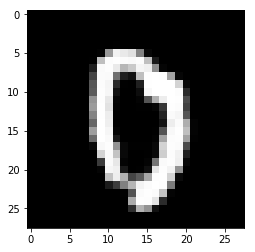

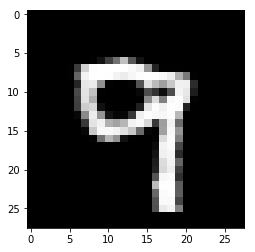

In [20]:
# generate samples

sess = tf.Session()
saver.restore(sess, './model/tf_model_gan.ckpt')
number_of_samples = 10

n = np.random.uniform(0.0, 1.0, [number_of_samples, n_noise]).astype(np.float32)   
      
s = sess.run(g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:False})

for i in range(number_of_samples):
    plt.imshow(np.reshape(s[i], [28, 28]), cmap = 'gray')
    plt.show()

sess.close()